In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, shape

from data.constants import (BUILDINGS_TABLE,
                            WORLD_CRS)
from data.cta import CTAClient
from data.geo import dms_to_decimal
import numpy as np

In [2]:
UNITED_CENTER = ((41,52,50,"N"), (87,40,27,"W")) # lat/lng
MCCORMICK_PLACE = ((41,51,7,"N"), (87,36,58,"W"))
SOLDIER_FIELD = ((41,51,44,"N"), (87,37,0,"W"))
WRIGLEY_FIELD = ((41,56,53,"N"), (87,39,20,"W"))
RATE_FIELD = ((41,49,48,"N"), (87,38,2,"W"))

In [3]:
client = CTAClient(60)

In [4]:
poi_file_out = "../data/raw/poi_buildings.geojson"

# Pipeline in

(None)

# Points of Interest

In [5]:
def search_buildings(latlng, radius=250):
    # Radius is in meters.
    xy = Point(dms_to_decimal(*latlng[1]), dms_to_decimal(*latlng[0])) # lng/lat
    candidates = client.soda_get_all(BUILDINGS_TABLE, 
            where=f"within_circle(the_geom, {xy.y}, {xy.x}, {radius})")
    candidates['geometry'] = candidates['the_geom'].apply(shape)
    candidates = gpd.GeoDataFrame(candidates, geometry='geometry', crs=WORLD_CRS)
    return candidates

def verify_buildings(bldgs, mask):
    bldgs.assign(mask=np.where(mask, 'blue','grey')).plot(column='mask')

## United Center

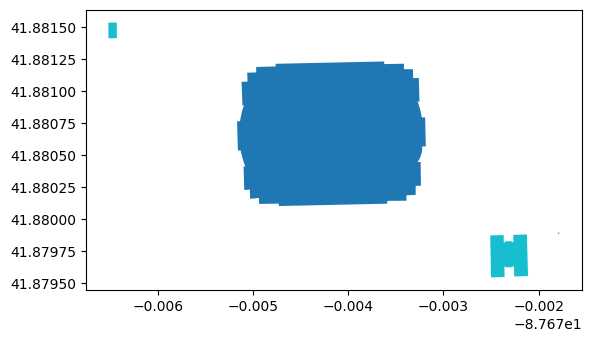

In [6]:
candidates = search_buildings(UNITED_CENTER, 250)
verify_buildings(candidates, candidates['bldg_name1'] == 'UNITED CENTER')

In [7]:
uc_building = candidates[candidates['bldg_name1'] == 'UNITED CENTER']

## McCormick Place

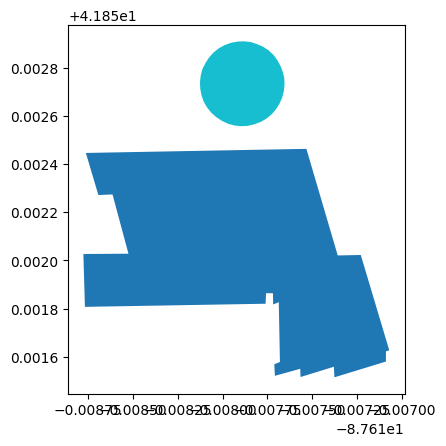

In [8]:
candidates = search_buildings(MCCORMICK_PLACE, 250)
verify_buildings(candidates, candidates['bldg_name1'] == 'HYATT REGENCY MCCORMICK PLACE')

In [9]:
mp_building = candidates[candidates['bldg_name1'] == 'HYATT REGENCY MCCORMICK PLACE']

## Soldier Field

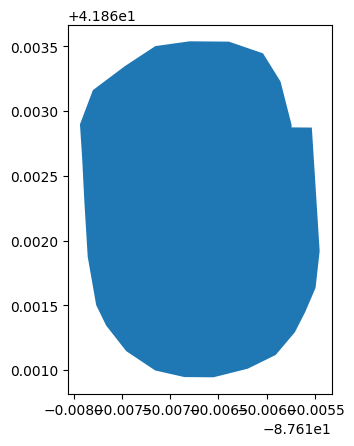

In [10]:
candidates = search_buildings(SOLDIER_FIELD, 250)
verify_buildings(candidates, candidates.index == 0)
# Unfortunately this entry doesn't have a building name or street name, but this is soldier field

In [11]:
soldier_building = candidates.iloc[0:1].assign(bldg_name1 = 'SOLDIER FIELD')

## Wrigley Field

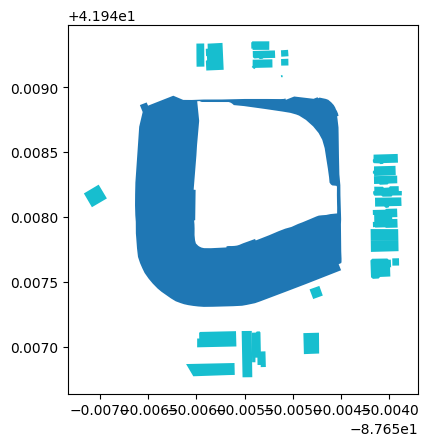

In [12]:
candidates = search_buildings(WRIGLEY_FIELD, 150)
verify_buildings(candidates, candidates.bldg_name1 == 'WRIGLEY FIELD')

In [13]:
wrigley_building = candidates[candidates.bldg_name1 == 'WRIGLEY FIELD']

## Rate Field

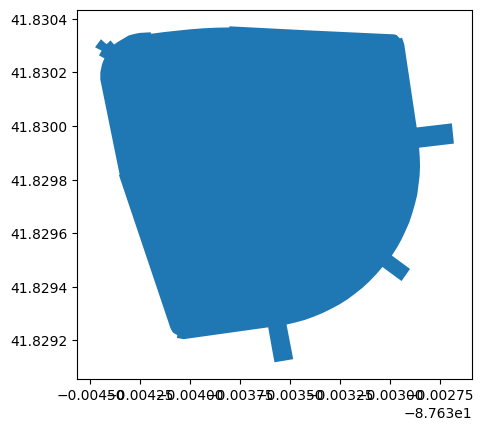

In [14]:
candidates = search_buildings(RATE_FIELD, 150)
verify_buildings(candidates, candidates.index == 0)
# This one also unfortunately doesn't have a name or street name but this is Comiskey.

In [15]:
assert len(candidates) == 1
rate_building = candidates.assign(bldg_name1 = "GUARANTEED RATE FIELD")

## POI Buildings

In [16]:
poi_buildings = pd.concat([mp_building, 
                           uc_building,
                           soldier_building,
                           wrigley_building,
                           rate_building], ignore_index=True)
poi_buildings = poi_buildings.filter(['geometry','bldg_name1']).rename(columns={'bldg_name1':'name'})

In [17]:
poi_buildings

,geometry,name
0,"MULTIPOLYGON (((-87.61738 41.85151, -87.61738 ...",HYATT REGENCY MCCORMICK PLACE
1,"MULTIPOLYGON (((-87.67473 41.8801, -87.67473 4...",UNITED CENTER
2,"MULTIPOLYGON (((-87.61794 41.8629, -87.6178 41...",SOLDIER FIELD
3,"MULTIPOLYGON (((-87.65592 41.94731, -87.65598 ...",WRIGLEY FIELD
4,"MULTIPOLYGON (((-87.63358 41.82912, -87.63359 ...",GUARANTEED RATE FIELD


# Pipeline out

In [18]:
poi_buildings.to_file(poi_file_out, index=False)